In [36]:
# === Standard library ===
import argparse
import bisect
import gc
import json
import os
import pickle
import random
import re
import shutil
import warnings
from collections import defaultdict
from time import perf_counter
from typing import Any, Dict, List, Optional, Tuple

# === Third-party utility ===
import av
import numpy as np
from IPython.display import HTML
from tqdm import tqdm

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adagrad
from torch.utils.data import DataLoader, Dataset

# === Transformers and HuggingFace Hub ===
from transformers import (
    AutoModel,
    AutoProcessor,
    AutoTokenizer,
    Qwen2_5_VLForConditionalGeneration,
    VideoLlavaForConditionalGeneration,
    VideoLlavaProcessor,
)
from transformers.generation.stopping_criteria import StoppingCriteria, StoppingCriteriaList
from huggingface_hub import hf_hub_download

# === Sentence Transformers ===
from sentence_transformers import SentenceTransformer

# === Local modules ===
from qwen_vl_utils import process_vision_info
# from video_qa_dataset import VideoQADataset  # Uncomment if used

import torch
import clip
from PIL import Image
import cv2
import numpy as np
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/jamesdin/MMML/STAR")
from visualization_utils import display_video_embed

In [2]:

import pickle
import pandas as pd

# --- Load Model ---
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype=torch.bfloat16, device_map="auto", attn_implementation="flash_attention_2"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")


# --- Load Data ---
# Load the .pkl file
with open('/data/user_data/jamesdin/STAR/data/STAR_val.pkl', 'rb') as f:
    data = pickle.load(f)
# Convert to DataFrame and set index
df = pd.DataFrame(data).set_index('question_id')


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:


class LookEndTokenStoppingCriteria(StoppingCriteria):
    def __init__(self, tokenizer, input_length, stop_string="</look>"):
        self.tokenizer = tokenizer
        self.stop_string = stop_string
        self.input_length = input_length
        
    def __call__(self, input_ids, scores, **kwargs):
        # For each sequence in the batch
        for input_id in input_ids:
            # Only look at newly generated tokens
            if len(input_id) <= self.input_length:
                continue
                
            # Decode the generated text (keeping special tokens)
            generated_text = self.tokenizer.decode(
                input_id[self.input_length:], 
                skip_special_tokens=False
            )
            
            # Simple string match for the stop string
            if self.stop_string in generated_text:
                return True
        return False

In [31]:

# def retrieve_frames(query: str, video_path: str, start: float, end: float) -> List[Dict]:
#     """
#     Retrieve relevant frames based on the query.
#     This is a placeholder for your actual retrieval logic.
    
#     Args:
#         query: The text query to search for in the video
#         video_path: Path to the video file
#         start: Start time in the video
#         end: End time in the video
        
#     Returns:
#         List of retrieved frames in the format needed by the model
#     """
#     # Implement your frame retrieval logic here
#     # This could be a call to a separate model or system
#     print(f"Retrieving frames for query: {query}")
    
#     # In a real implementation, this function would:
#     # 1. Process the query to identify relevant time points in the video
#     # 2. Extract frames from those time points
#     # 3. Return the frames in the format expected by your model
    
#     # For demonstration, let's assume we've retrieved 3 frames from different times
#     # This is a placeholder - you'll replace this with your actual retrieval logic
    
#     image_path = "/data/user_data/jamesdin/test_data/001.jpg"  # dummy image
#     messages =  [
#             {
#                 "role": "user",
#                 "content": [
#                     {"type": "image", "image": image_path},
#                 ],
#             }
#     ]
#     retrieved_frames, _ = process_vision_info(messages)
    
#     # IMPORTANT: Make sure the format matches exactly what your model expects
#     # This should match the format in your original code's user message
#     # return [
#     #     {
#     #         "type": "image",
#     #         "image": f"{video_path}_retrieved_frame_{i}.jpg",  # Path to retrieved frame
#     #         "caption": f"Retrieved frame for query: {query}"
#     #     }
#     #     for i in range(3)  # Returning 3 sample frames
#     # ]
#     return retrieved_frames


In [34]:
retrieve_frames(0,0,0,0)

Retrieving frames for query: 0


[<PIL.Image.Image image mode=RGB size=364x476>]

In [111]:
def interactive_video_qa(
    video_qa_model,
    processor,
    system_prompt,
    user_prompt,
    video_path: str,
    start: float,
    end: float,
    question: str,
    choices: List[str],
    max_iterations: int = 5,
    device: str = "cuda"
) -> str:
    """
    Run an interactive video QA pipeline with look-and-retrieve functionality.
    
    Args:
        video_qa_model: The main language model for reasoning
        processor: Processor for the model
        system_prompt: System prompt
        user_prompt: User prompt template
        video_path: Path to the video file
        start: Start time in the video
        end: End time in the video
        question: The question to answer
        choices: List of possible answers
        max_iterations: Maximum number of look-retrieve cycles
        device: Device to run inference on
        
    Returns:
        The complete generated response
    """

    # Do not add this section for the zero-shot evaluation, because the model didn't not learn to generate this token yet
    # Add this part before the training.
    # Add special tokens to the tokenizer
    # special_tokens = {'additional_special_tokens': ['<look>', '</look>']}
    # processor.tokenizer.add_special_tokens(special_tokens)

    # # Resize the model's token embeddings to accommodate the new tokens
    # model.resize_token_embeddings(len(processor.tokenizer))

    # # Get the token IDs for later use
    # look_token_id = processor.tokenizer.convert_tokens_to_ids('<look>')
    # look_end_token_id = processor.tokenizer.convert_tokens_to_ids('</look>')

    # print(f"New tokens added: <look>: {look_token_id}, </look>: {look_end_token_id}")

    frame_retriever = CLIPKeyFrameExtractor()

    # Format the user prompt with the question and choices
    formatted_user_prompt = user_prompt.format(
        question=question,
        choices=''.join([f"{i+1}. {c}" + chr(10) for i, c in enumerate(choices)])
    )

    # Initial messages with video
    messages = [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": system_prompt},
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": video_path,
                    "video_start": start,
                    "video_end": end,
                    "nframes": 8
                },
                {"type": "text", "text": formatted_user_prompt},
            ],
        }
    ]

    # Prepare the initial template only once
    base_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    current_text = base_text  # Text to be used for this iteration
    
    # Initialize variables
    full_response = ""  # The accumulated assistant's response
    image_inputs = None   # Will hold retrieved frames
    
    # Extract initial video inputs
    _, video_inputs = process_vision_info(messages)
    
    print(f"[Start] Starting generation, max iterations: {max_iterations}")

    # Perform iterative generation with look-retrieve cycles
    for iteration in range(max_iterations):
        
        current_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        
        # Prepare inputs for the processor
        inputs = processor(
            text=[current_text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(device)

        # Set up stopping criteria to find </look> tokens in newly generated content
        input_length = len(inputs.input_ids[0])
        look_stopping_criteria = LookEndTokenStoppingCriteria(
            processor.tokenizer,
            input_length=input_length,
            stop_string="</look>"
        )
        
        # Generate text with stopping at </look>
        outputs = video_qa_model.generate(
            **inputs,
            max_new_tokens=100,
            stopping_criteria=StoppingCriteriaList([look_stopping_criteria]),
        )

        # Decode the generated text
        input_length = len(inputs.input_ids[0])
        generated_ids = outputs[0]
        new_token_ids = generated_ids[input_length:]

        # Decode only the new tokens to text
        new_content = processor.tokenizer.decode(
            new_token_ids, 
            skip_special_tokens=False, 
            clean_up_tokenization_spaces=False
        )
        
        print(f"[Iteration {iteration}] New content: {new_content}")

        # Check if we have a look query
        look_match = re.search(r"<look>(.*?)</look>", new_content)
        if look_match:
            # Extract the query
            query = look_match.group(1).strip()
            # before_look = new_content[:look_match.end()]  # Include the </look> tag
            # # before_look = new_content[:look_match.start()]
            
            # # Update full response
            full_response += new_content
            
            print(f"[Iteration {iteration}] Retrieved frames for query: {query}")
            
            # Retrieve frames based on the query
            retrieved_frames = retrieve_frames(frame_retriever, query, video_path, start, end)
            
            # Add the retrieved frames to image_inputs
            if not image_inputs:
                image_inputs = retrieved_frames
            else:
                image_inputs.extend(retrieved_frames)
            
            # Update the current text for next iteration
            # We need to include: original prompt + full response so far + vision markers
            current_text = base_text + full_response
            
            if messages[-1]['role'] != 'assistant':
                messages.append({"role": "assistant", "content": []})
            
            messages[-1]['content'].append({"type": "text", "text": new_content})
            
            # Add vision markers for each new frame in the format Qwen expects
            for frame in retrieved_frames:
                # current_text += "<|vision_start|><|image_pad|><|vision_end|>"
                # new_content += str(frame)  # can print out the actual retrieved frames for visualization
                
                messages[-1]['content'].append({"type": "image", "image": "dummy_path"})
                
                print(f"[Iteration {iteration}] Retrieved frames: {str(frame)}")
            
        else:
            # No more look queries, finalize the response
            full_response += new_content
            break

    return full_response


In [112]:
system_prompt = "You are a helpful video reasoning assistant."
user_prompt = """
You are a video reasoning assistant. When answering questions about video content:

- Use numbered steps to reason through the problem.
- When you need visual information, write a single line with: <look> your query </look>
  (This will retrieve frames from the video for you to use in your next step.)
- End with: Answer: <choice number>. <choice text>

Follow the examples below:

--------------------------------------------------
Example 1
Question: What does the chef do *after* adding salt?
Choices:
1. Tastes the soup.
2. Adds pepper.
3. Turns off the stove.
4. Puts on the lid.

Step 1: I need to see what the chef does right after adding salt.
<look> chef’s hands immediately after salt is poured </look>
<assume there are some retrieved frames here>
Step 2: The chef grabs a pepper shaker and adds pepper to the pot.
Step 3: So the action that follows adding salt is adding pepper.
Answer: 2. Adds pepper.
--------------------------------------------------
Example 2
Question: Why does the girl scream?
Choices:
1. She sees a mouse.
2. She drops her ice cream.
3. Someone surprises her.
4. She wins a prize.

Step 1: First, check the scene right before the girl screams.
<look> frames right before the girl screams </look>
<assume there are some retrieved frames here>
Step 2: A person jumps out from behind the door.
Step 3: So the girl screams because she was startled.
Answer: 3. Someone surprises her.
--------------------------------------------------

Now answer the following:

Question: {question}
Choices:
{choices}
"""

In [122]:

harder_user_prompt = """
You are a video reasoning assistant. When answering questions about video content:

- Use numbered steps to reason through the problem.
- When you need visual information, write a single line with: <look> your query </look>
  (This will retrieve frames from the video for you to use in your next step.)
- End with: Answer: <choice number>. <choice text>

Follow the examples below:

--------------------------------------------------
Example 1
Question: What causes the woman to run out of the house?
Choices:
1. She receives a phone call.
2. She hears a loud noise.
3. She sees something on TV.
4. She smells smoke in the kitchen.

Step 1: Start by checking what the woman is doing before she runs out.
<look> actions of the woman before she exits the house </look>
<assume there are some retrieved frames here>
Step 2: She is cooking in the kitchen and suddenly reacts to something.
Step 3: Check if there is something on the stove or in the kitchen that causes alarm.
<look> stove area and surroundings during cooking </look>
<assume there are some retrieved frames here>
Step 4: There is smoke rising from the pan.
Step 5: Check if she responds to the smoke or something else.
<look> her facial reaction and response after seeing smoke </look>
<assume there are some retrieved frames here>
Step 6: She covers her nose, looks panicked, and runs out.
Answer: 4. She smells smoke in the kitchen.
--------------------------------------------------
Example 2
Question: What did the boy do after realizing his toy was broken?
Choices:
1. He asked an adult for help.
2. He cried.
3. He threw it away.
4. He tried to fix it with tape.

Step 1: First, verify when the boy discovers the toy is broken.
<look> moment the boy inspects the toy </look>
<assume there are some retrieved frames here>
Step 2: He twists the toy, and a piece falls off.
Step 3: Check his immediate emotional reaction.
<look> his facial expression right after the toy breaks </look>
<assume there are some retrieved frames here>
Step 4: He looks upset but focused rather than sad.
Step 5: Check what he does next—does he go somewhere or grab something?
<look> actions following the reaction — does he grab anything? </look>
<assume there are some retrieved frames here>
Step 6: He grabs tape from a drawer and starts wrapping it around the toy.
Answer: 4. He tried to fix it with tape.
--------------------------------------------------

Now answer the following:

Question: {question}
Choices:
{choices}
"""


In [49]:
df.index

Index(['Interaction_T1_13', 'Interaction_T1_14', 'Interaction_T1_31',
       'Interaction_T1_32', 'Interaction_T1_40', 'Interaction_T1_43',
       'Interaction_T1_70', 'Interaction_T1_71', 'Interaction_T1_76',
       'Interaction_T1_78',
       ...
       'Feasibility_T6_1414', 'Feasibility_T6_1428', 'Feasibility_T6_1430',
       'Feasibility_T6_1448', 'Feasibility_T6_1449', 'Feasibility_T6_1453',
       'Feasibility_T6_1454', 'Feasibility_T6_1455', 'Feasibility_T6_1456',
       'Feasibility_T6_1468'],
      dtype='object', name='question_id', length=7098)

In [124]:

# question_id = 'Sequence_T1_6700'

question_id = 'Interaction_T1_78'

example = df.loc[question_id]
video_id = example['video_id']
video_path = f"/data/user_data/jamesdin/STAR/data/Charades_v1_480/{video_id}.mp4"
question = example['question']
choices = [x['choice'] for x in example['choices']]
start = example['start']
end = example['end']


In [125]:
display_video_embed(video_id)

Embedding video: /data/user_data/jamesdin/STAR/data/Charades_v1_480/OY3LS.mp4


In [126]:
question

'Which object was opened by the person?'

In [127]:
choices

['The laptop.', 'The refrigerator.', 'The door.', 'The bag.']

In [117]:
question1 = "The person is putting down the bag"

In [134]:
def retrieve_frames(frame_retriever, query: str, video_path: str, start: float, end: float) -> List[Dict]:
    """
    Retrieve relevant frames based on the query using CLIP-based frame selection.
    
    Args:
        query: The text query to search for in the video
        video_path: Path to the video file
        start: Start time in the video
        end: End time in the video
        frame_retriever: An instance of CLIPKeyFrameExtractor
        
    Returns:
        List of retrieved frames in the format needed by the model
    """
    print(f"Retrieving frames for query: {query}")
    
    # Extract key frames using the provided frame retriever
    key_frames_data = frame_retriever.extract_key_frames(
        video_path=video_path,
        question=query,
        sample_rate=5,  # Sample every 5th frame to speed up processing
        top_k=1,        # Return 3 most relevant frames
        min_distance=10, # Minimum distance between frames
        start=start,
        end=end,
        visualize=True  # Don't visualize results
    )
    
    # Convert numpy array frames to PIL Images
    retrieved_frames = [Image.fromarray(frame) for frame in key_frames_data["frames"]]
    
    return retrieved_frames

In [106]:
frame_retriever = CLIPKeyFrameExtractor()

CLIP model loaded on cuda


Retrieving frames for query: What is the person able to do after closing the door?
Processing video: /data/user_data/jamesdin/STAR/data/Charades_v1_480/CCCUJ.mp4
Question: What is the person able to do after closing the door?
Video has 1776 frames at 29.376 FPS, duration: 60.46s
Extracting frames from 11.60s to 18.90s
Frame range: 340 to 555
Processed 100/215 frames (46.5%)
Processed 200/215 frames (93.0%)
Extracted 43 frames at sample rate 5
Encoded frames 0 to 32/43
Encoded frames 32 to 43/43


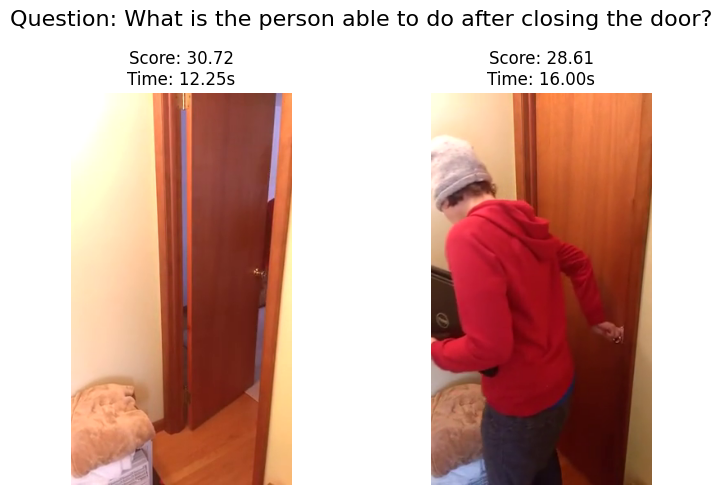

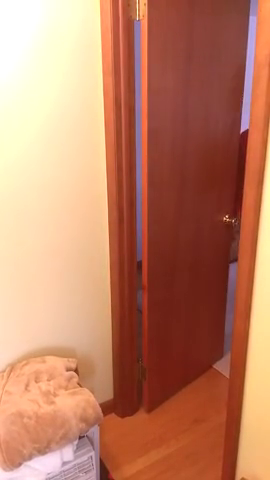

In [120]:
retrieve_frames(frame_retriever, question, video_path, start, end)[0]

In [99]:
user_prompt

'\nYou are a video reasoning assistant. When answering questions about video content:\n\n- Use numbered steps to reason through the problem.\n- When you need visual information, write a single line with: <look> your query </look>\n  (This will retrieve frames from the video for you to use in your next step.)\n- End with: Answer: <choice number>. <choice text>\n\nFollow the examples below:\n\n--------------------------------------------------\nExample 1\nQuestion: What does the chef do *after* adding salt?\nChoices:\n1. Tastes the soup.\n2. Adds pepper.\n3. Turns off the stove.\n4. Puts on the lid.\n\nStep 1: I need to see what the chef does right after adding salt.\n<look> chef’s hands immediately after salt is poured </look>\nStep 2: The chef grabs a pepper shaker and adds pepper to the pot.\nStep 3: So the action that follows adding salt is adding pepper.\nAnswer: 2. Adds pepper.\n--------------------------------------------------\nExample 2\nQuestion: Why does the girl scream?\nChoi

video_reader_backend decord error, use torchvision as default, msg: not support start_pts and end_pts in decord for now.


CLIP model loaded on cuda
[Start] Starting generation, max iterations: 5
[Iteration 0] New content: Step 1: Identify the objects present in the scene.
<look> objects in the room including the door, bag, and other items </look>

[Iteration 0] Retrieved frames for query: objects in the room including the door, bag, and other items
Retrieving frames for query: objects in the room including the door, bag, and other items
Processing video: /data/user_data/jamesdin/STAR/data/Charades_v1_480/OY3LS.mp4
Question: objects in the room including the door, bag, and other items
Video has 495 frames at 11.0 FPS, duration: 45.00s
Extracting frames from 2.50s to 10.10s
Frame range: 27 to 111
Extracted 17 frames at sample rate 5
Encoded frames 0 to 17/17


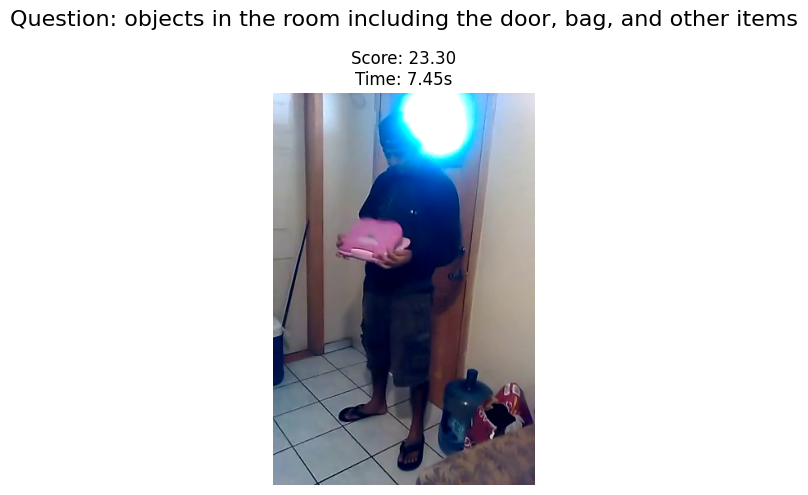

[Iteration 0] Retrieved frames: <PIL.Image.Image image mode=RGB size=320x480 at 0x7F6470130E20>
[Iteration 1] New content: Step 2: Determine which object the person is interacting with.
<look> the person's hand movements and focus </look>

[Iteration 1] Retrieved frames for query: the person's hand movements and focus
Retrieving frames for query: the person's hand movements and focus
Processing video: /data/user_data/jamesdin/STAR/data/Charades_v1_480/OY3LS.mp4
Question: the person's hand movements and focus
Video has 495 frames at 11.0 FPS, duration: 45.00s
Extracting frames from 2.50s to 10.10s
Frame range: 27 to 111
Extracted 17 frames at sample rate 5
Encoded frames 0 to 17/17


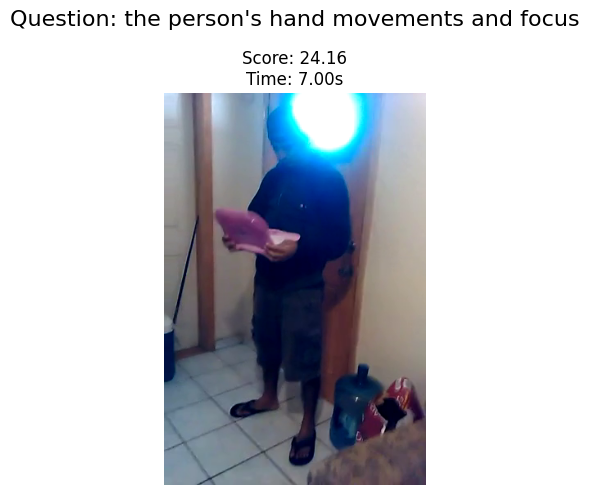

[Iteration 1] Retrieved frames: <PIL.Image.Image image mode=RGB size=320x480 at 0x7F6476403520>
[Iteration 2] New content: Answer: 4. The bag.<|im_end|>
Final response:
Step 1: Identify the objects present in the scene.
<look> objects in the room including the door, bag, and other items </look>
Step 2: Determine which object the person is interacting with.
<look> the person's hand movements and focus </look>
Answer: 4. The bag.<|im_end|>


In [135]:

# --- Run Model ---
result = interactive_video_qa(
    model,
    processor,
    system_prompt,
    harder_user_prompt,
    video_path,
    start,
    end,
    question,
    choices,
)

print("Final response:")
print(result)


In [38]:
class CLIPKeyFrameExtractor:
    def __init__(self, clip_model_name: str = "ViT-B/32"):
        """
        Initialize the CLIP-based key frame extractor.

        Args:
            clip_model_name: The CLIP model variant to use
        """
        # Load the CLIP model
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load(clip_model_name, device=self.device)
        print(f"CLIP model loaded on {self.device}")

    def extract_frames(self, video_path: str, start: float = 0.0, end: float = None, sample_rate: int = 1) -> List[np.ndarray]:
        """
        Extract frames from the video at the given sample rate within a specified time range.
    
        Args:
            video_path: Path to the video file
            start: Start timestamp in seconds (default: 0.0, i.e., from the beginning)
            end: End timestamp in seconds (default: None, i.e., until the end)
            sample_rate: Sample every nth frame (default: 1, i.e., extract all frames)
    
        Returns:
            List of extracted frames as numpy arrays, frame indices, and fps
        """
        frames = []
        frame_indices = []
    
        # Open the video file
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video file: {video_path}")
    
        # Get video properties
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = total_frames / fps
        
        # Calculate start and end frames
        start_frame = int(start * fps) if start is not None else 0
        end_frame = int(end * fps) if end is not None else total_frames
        
        print(f"Video has {total_frames} frames at {fps} FPS, duration: {duration:.2f}s")
        print(f"Extracting frames from {start:.2f}s to {end if end is not None else duration:.2f}s")
        print(f"Frame range: {start_frame} to {end_frame}")
        
        # Set the starting position
        if start_frame > 0:
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        # Extract frames within the specified range
        frame_idx = start_frame
        while frame_idx < end_frame:
            ret, frame = cap.read()
            if not ret:
                break
    
            if (frame_idx - start_frame) % sample_rate == 0:
                # Convert BGR to RGB (OpenCV uses BGR by default)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame_rgb)
                frame_indices.append(frame_idx)
    
            frame_idx += 1
    
            # Print progress every 100 frames
            if (frame_idx - start_frame) % 100 == 0:
                progress = (frame_idx - start_frame) / (end_frame - start_frame)
                print(f"Processed {frame_idx - start_frame}/{end_frame - start_frame} frames ({progress:.1%})")
    
        cap.release()
        print(f"Extracted {len(frames)} frames at sample rate {sample_rate}")
        return frames, frame_indices, fps
    
    def get_frame_timestamps(self, frame_indices: List[int], fps: float) -> List[float]:
        """
        Convert frame indices to timestamps in seconds.

        Args:
            frame_indices: List of frame indices
            fps: Frames per second of the video

        Returns:
            List of timestamps in seconds
        """
        return [idx / fps for idx in frame_indices]

    def encode_question(self, question: str) -> torch.Tensor:
        """
        Encode the question using CLIP's text encoder.

        Args:
            question: The question text

        Returns:
            The encoded question tensor
        """
        # Tokenize and encode the question
        with torch.no_grad():
            text_inputs = clip.tokenize([question]).to(self.device)
            question_features = self.model.encode_text(text_inputs)
            # Normalize the features
            question_features = question_features / question_features.norm(dim=-1, keepdim=True)

        return question_features

    def encode_frames(self, frames: List[np.ndarray]) -> torch.Tensor:
        """
        Encode the frames using CLIP's image encoder.

        Args:
            frames: List of frames as numpy arrays

        Returns:
            The encoded frame tensors
        """
        frame_features = []

        # Process frames in batches to avoid memory issues
        batch_size = 32
        num_frames = len(frames)

        for i in range(0, num_frames, batch_size):
            batch_frames = frames[i:i + batch_size]

            # Preprocess the batch of frames
            preprocessed_frames = torch.stack([
                self.preprocess(Image.fromarray(frame))
                for frame in batch_frames
            ]).to(self.device)

            # Encode the batch of frames
            with torch.no_grad():
                batch_features = self.model.encode_image(preprocessed_frames)
                # Normalize the features
                batch_features = batch_features / batch_features.norm(dim=-1, keepdim=True)

            frame_features.append(batch_features)

            print(f"Encoded frames {i} to {min(i + batch_size, num_frames)}/{num_frames}")

        # Concatenate all batches
        frame_features = torch.cat(frame_features, dim=0)

        return frame_features

    def compute_similarities(self, question_features: torch.Tensor, frame_features: torch.Tensor) -> torch.Tensor:
        """
        Compute the cosine similarities between the question and all frames.

        Args:
            question_features: The encoded question
            frame_features: The encoded frames

        Returns:
            Tensor of similarity scores for each frame
        """
        # Compute cosine similarities
        similarities = (100.0 * question_features @ frame_features.T).squeeze()

        return similarities

    def select_key_frames(
        self,
        similarities: torch.Tensor,
        frames: List[np.ndarray],
        frame_indices: List[int],
        timestamps: List[float],
        top_k: int = 5,
        similarity_threshold: float = None,
        min_distance: int = 0
    ) -> Dict:
        """
        Select the top-k most relevant frames based on similarity scores.

        Args:
            similarities: Tensor of similarity scores
            frames: List of all extracted frames
            frame_indices: List of frame indices
            timestamps: List of frame timestamps
            top_k: Number of key frames to select
            similarity_threshold: Minimum similarity score required (optional)
            min_distance: Minimum distance between selected frames in terms of indices

        Returns:
            Dictionary containing selected frames, indices, timestamps, and scores
        """
        # Convert similarities to numpy array
        similarities_np = similarities.cpu().numpy()

        # Apply threshold if provided
        if similarity_threshold is not None:
            valid_indices = np.where(similarities_np >= similarity_threshold)[0]
            if len(valid_indices) == 0:
                print(f"No frames with similarity >= {similarity_threshold} found.")
                # Fall back to top-k without threshold
                valid_indices = np.arange(len(similarities_np))
        else:
            valid_indices = np.arange(len(similarities_np))

        # Get top-k indices with minimum distance constraint
        selected_indices = []

        # Sort valid indices by similarity score (descending)
        sorted_indices = valid_indices[np.argsort(-similarities_np[valid_indices])]

        for idx in sorted_indices:
            # Check if the current index is far enough from already selected indices
            if all(abs(idx - selected_idx) >= min_distance for selected_idx in selected_indices) or not selected_indices:
                selected_indices.append(idx)

            # Stop when we have enough frames
            if len(selected_indices) >= top_k:
                break

        # If we couldn't find enough frames with the distance constraint, relax it
        if len(selected_indices) < top_k and min_distance > 0:
            print(f"Could only find {len(selected_indices)} frames with min_distance={min_distance}.")
            print("Relaxing distance constraint...")
            remaining = top_k - len(selected_indices)

            # Consider indices not yet selected
            remaining_indices = [idx for idx in sorted_indices if idx not in selected_indices]
            selected_indices.extend(remaining_indices[:remaining])

        # Sort selected indices by their position in the video
        selected_indices.sort()

        # Gather the selected frames, their original indices, timestamps, and scores
        key_frames = [frames[idx] for idx in selected_indices]
        key_frame_indices = [frame_indices[idx] for idx in selected_indices]
        key_timestamps = [timestamps[idx] for idx in selected_indices]
        key_scores = [similarities_np[idx] for idx in selected_indices]

        return {
            "frames": key_frames,
            "indices": key_frame_indices,
            "timestamps": key_timestamps,
            "scores": key_scores
        }

    def visualize_key_frames(self, key_frames_data: Dict, question: str, output_path: str = None):
        """
        Visualize the selected key frames with their similarity scores.

        Args:
            key_frames_data: Dictionary containing key frames data
            question: The original question
            output_path: Path to save the visualization (optional)
        """
        key_frames = key_frames_data["frames"]
        scores = key_frames_data["scores"]
        timestamps = key_frames_data["timestamps"]

        n_frames = len(key_frames)

        # Set up the figure
        fig, axes = plt.subplots(1, n_frames, figsize=(n_frames * 4, 5))
        if n_frames == 1:
            axes = [axes]

        # Set the figure title to the question
        fig.suptitle(f"Question: {question}", fontsize=16)

        # Plot each key frame
        for i, (frame, score, timestamp) in enumerate(zip(key_frames, scores, timestamps)):
            axes[i].imshow(frame)
            axes[i].set_title(f"Score: {score:.2f}\nTime: {timestamp:.2f}s")
            axes[i].axis("off")

        plt.tight_layout()

        # Save the figure if output path is provided
        if output_path:
            plt.savefig(output_path, dpi=150, bbox_inches="tight")
            print(f"Visualization saved to {output_path}")

        plt.show()

    def extract_key_frames(self, video_path: str, question: str, sample_rate: int = 1,
        top_k: int = 5, similarity_threshold: float = None, min_distance: int = 0,
        start: Optional[int] = None, end: Optional[int] = None, 
        visualize: Optional[bool] = False, output_dir: Optional[str] = None) -> Dict:
        """
        Extract key frames from a video that are most relevant to the given question.
    
        Args:
            video_path: Path to the video file
            question: The question about the video
            sample_rate: Sample every nth frame
            top_k: Number of key frames to extract
            similarity_threshold: Minimum similarity score required
            min_distance: Minimum distance between selected frames
            visualize: Whether to visualize the results
            output_dir: Directory to save the extracted frames
    
        Returns:
            Dictionary containing key frames data
        """
        print(f"Processing video: {video_path}")
        print(f"Question: {question}")
    
        # Extract frames from the video
        frames, frame_indices, fps = self.extract_frames(video_path, start, end, sample_rate)
        timestamps = self.get_frame_timestamps(frame_indices, fps)
    
        # Encode the question
        question_features = self.encode_question(question)
    
        # Encode the frames
        frame_features = self.encode_frames(frames)
    
        # Compute similarities between question and frames
        similarities = self.compute_similarities(question_features, frame_features)
    
        # Select key frames based on similarities
        key_frames_data = self.select_key_frames(
            similarities, frames, frame_indices, timestamps,
            top_k, similarity_threshold, min_distance
        )
    
        # Save the key frames if output_dir is provided
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            for i, frame in enumerate(key_frames_data["frames"]):
                frame_path = os.path.join(output_dir, f"{i+1}.png")
                # Convert RGB to BGR for OpenCV
                frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                cv2.imwrite(frame_path, frame_bgr)
                print(f"Saved frame to {frame_path}")
            
            # Add the frame paths to the output data
            key_frames_data["frame_paths"] = [
                os.path.join(output_dir, f"{i+1}.png") 
                for i in range(len(key_frames_data["frames"]))
            ]
    
        # Visualize the results if requested
        if visualize:
            visualization_path = os.path.join(output_dir, "visualization.png") if output_dir else None
            self.visualize_key_frames(key_frames_data, question, visualization_path)
    
        return key_frames_data